In [26]:
import sys
import yaml
from PIL import Image
import numpy as np
import torch
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

sys.path.append("../")

from src.models.vit import VisionTransformer
from src.data_utils.dataset import PlantDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_path = Path("../configs/vit_2021.yaml")
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

model_params = cfg["model"]["params"]
data_dir = Path("../data/raw")
image_size = cfg["data"]["image_size"]
weights_path = Path("../data/best_model.pt")

In [27]:
model = VisionTransformer(**model_params).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

/opt/miniconda3/envs/ml/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


VisionTransformer(
  (patch_embed): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (pos_drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=38, bias=True)
)

In [28]:
test_dataset = PlantDataset(
    root=data_dir / "test",
    image_size=image_size,
    is_train=False,
)

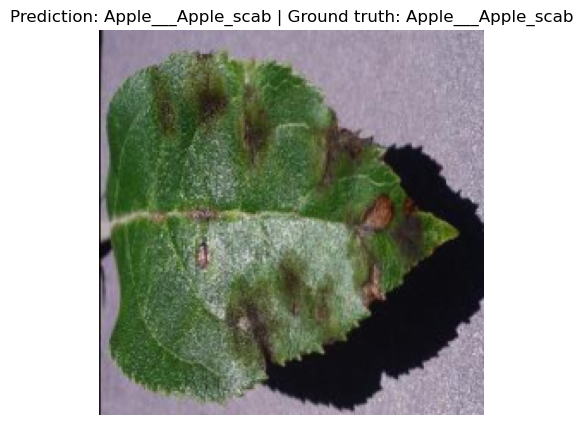

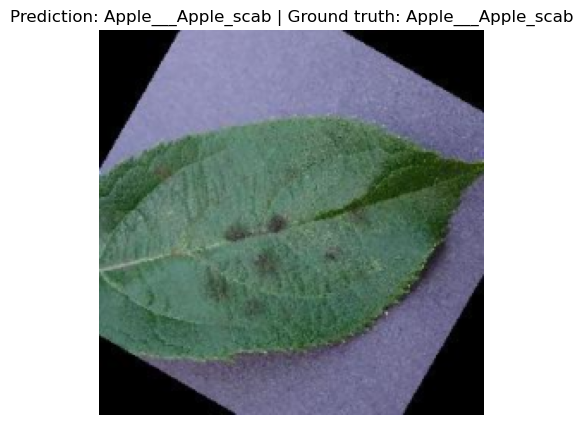

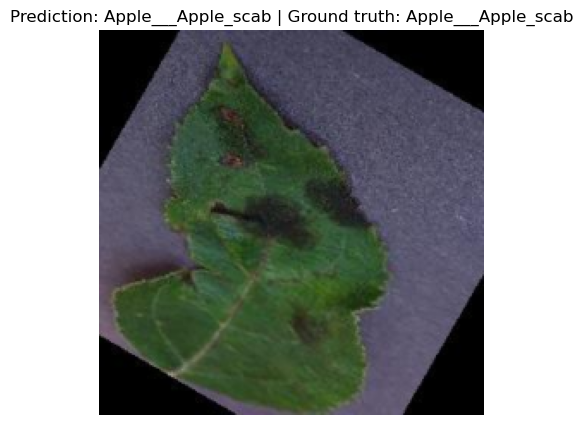

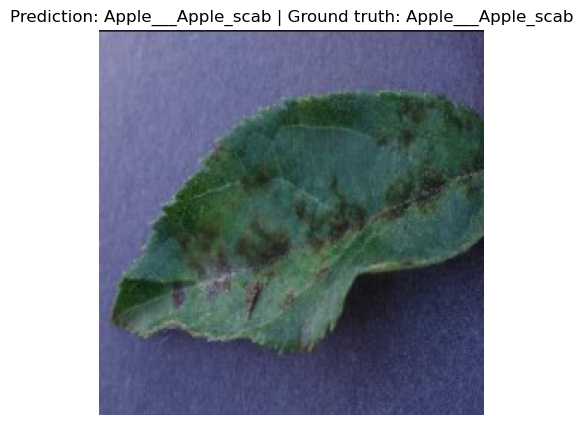

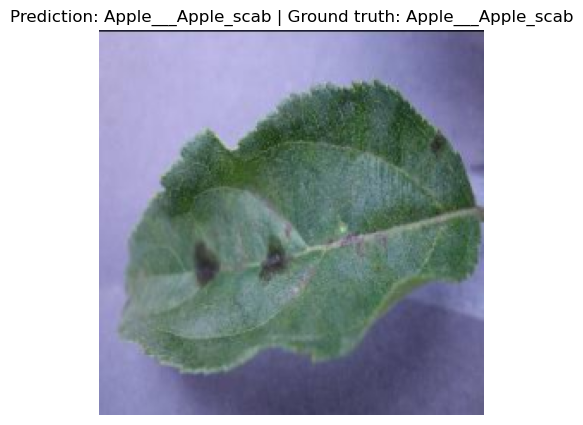

In [31]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

classes = sorted([p.name for p in (Path("../data/raw/test")).iterdir() if p.is_dir()])

def predict_and_show(dataset, idx):
    img, label = dataset[idx]

    img_batch = img.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_batch)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    img = img * std + mean
    img = img.clamp(0, 1)
    img_np = img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Prediction: {classes[pred_class]} | Ground truth: {classes[label]}")
    plt.show()

for i in range(5, 10):
    predict_and_show(test_dataset, i)

In [35]:
img, label = test_dataset[0]
img = img * std + mean
img = img.clamp(0, 1)
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    features = model.forward_features(img_batch)  # shape [1, num_patches+1, emb_dim]

cls_feat = features[0, 0].cpu().numpy() 

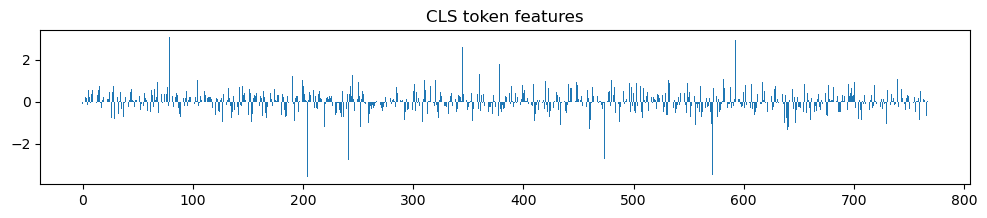

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 2))
plt.bar(np.arange(len(cls_feat)), cls_feat)
plt.title("CLS token features")
plt.show()

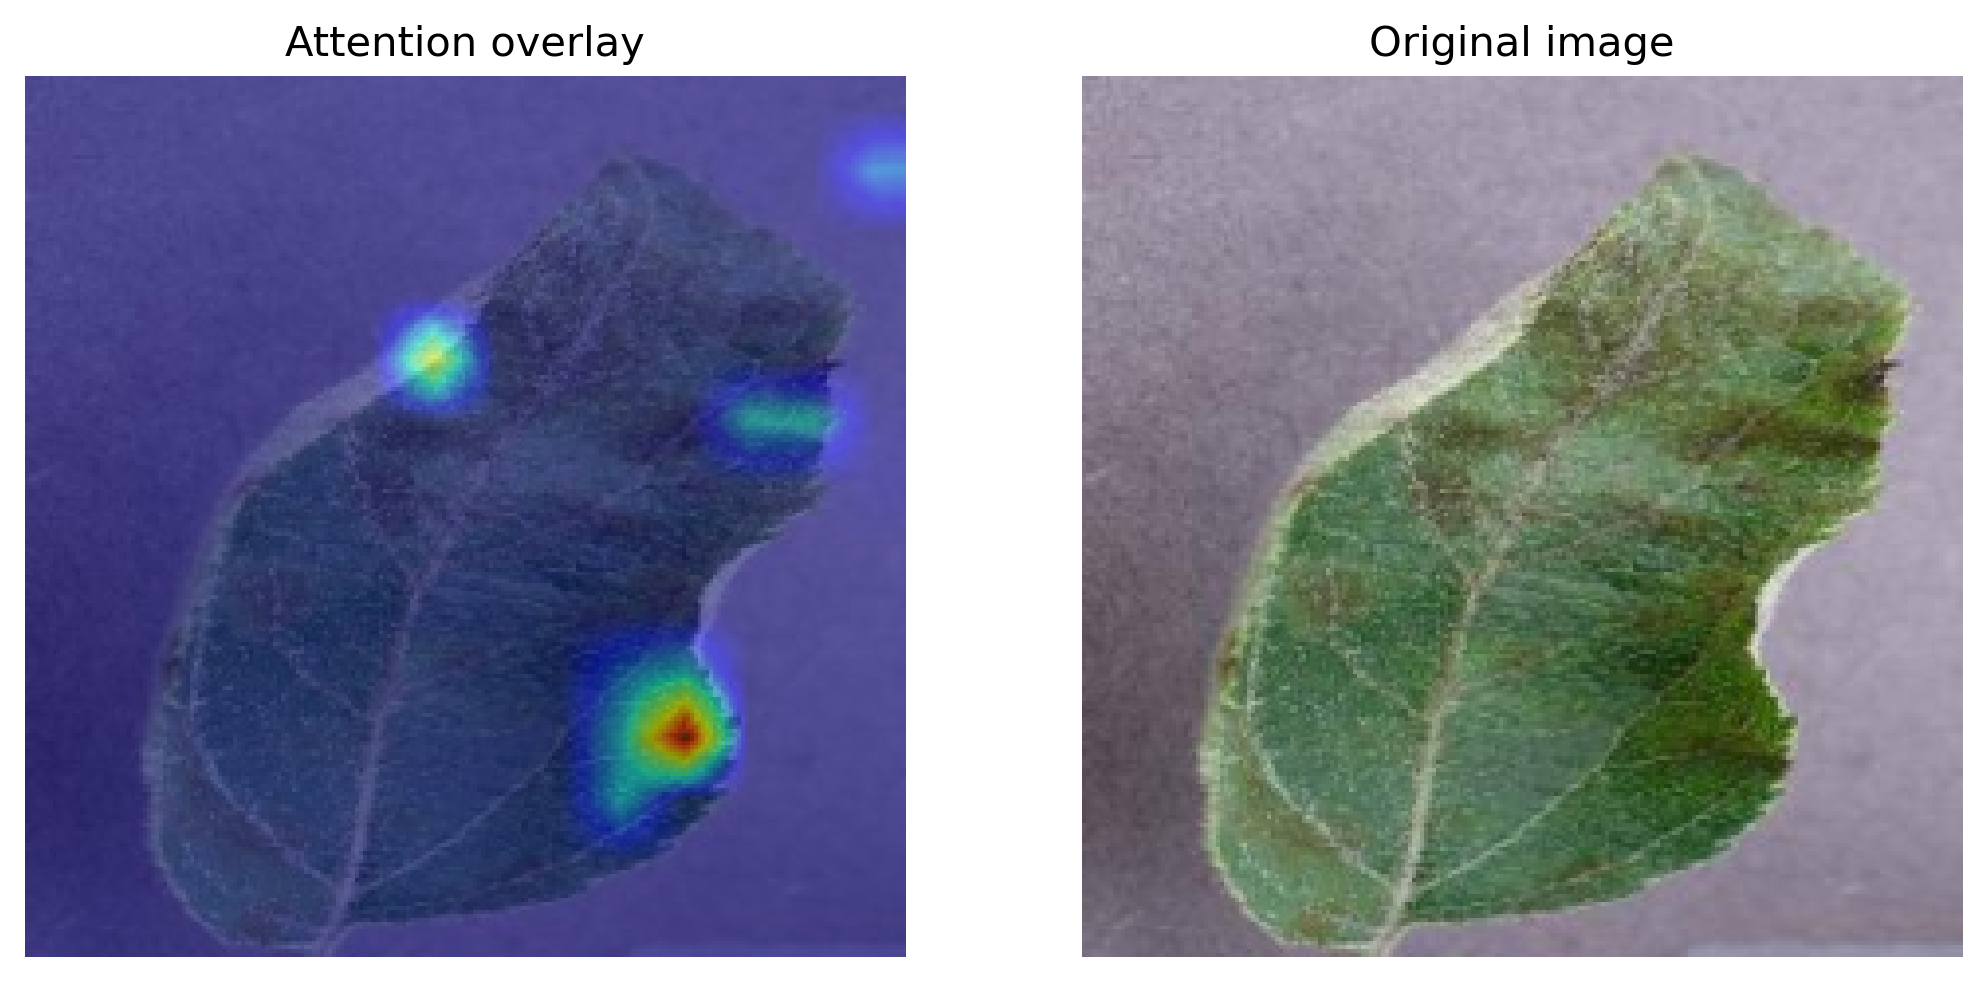

In [84]:
def visualize_vit_attention(model, img_tensor):
    model.eval()
    img_batch = img_tensor.unsqueeze(0).to(device)

    x = model.patch_embed(img_batch)
    B, C, H_patch, W_patch = x.shape
    num_patches = H_patch * W_patch
    x = x.flatten(2).transpose(1, 2)  # [B, num_patches, emb_dim]
    cls_tokens = model.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + model.pos_embed
    x = model.pos_drop(x)
    layer = model.encoder.layers[0]
    attn_module = layer.self_attn
    attn_output, attn_weights = attn_module(
        x, x, x, need_weights=True, average_attn_weights=False
    )
    cls_attn = attn_weights[0].mean(0)[0, 1:]

    patch_size = int(num_patches**0.5)
    attn_map = (
        cls_attn[: patch_size**2].reshape(patch_size, patch_size).detach().numpy()
    )
    attn_map = cv2.resize(attn_map, (img_tensor.shape[2], img_tensor.shape[1]))
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 5), dpi=250)

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Attention overlay")

    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original image")

    plt.show()


img, label = test_dataset[31]
img = img * std + mean
img = img.clamp(0, 1)
visualize_vit_attention(model, img)